<h1> Epitope Prediction </h1>

This tutorial illustrates the use of Fred2 to predict HLA-I/II epitopes and how to analyze results. Fred2 offers a long list of epitope prediction methods and was designed in such a way that extending Fred2 with your favorite method is easy.

This tutorial will entail:
- Simple epitope prediction from a list of peptide sequences and protein sequences
- Manipulation of the results
- Consensus prediction with multiple prediction methods
- Integration of a new prediction method


<h2> Chapter 1: The basics </h2>
<br/>
We first start with importing the needed packages.

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from Fred2.Core import Allele, Peptide, Protein,generate_peptides_from_proteins
from Fred2.IO import read_lines, read_fasta
from Fred2.EpitopePrediction import EpitopePredictorFactory

Lets start of with something simple: Defining peptides, and HLA alleles. You find all basic classes under `Fred2.Core`. HLA alleles have to be defined in new nomenclature (see: <a href="http://hla.alleles.org/">http://hla.alleles.org/</a>).

In [6]:
peptides = [Peptide("SYFPEITHI"),Peptide("FIASNGVKL"), Peptide("LLGATCMFV")]
allele = Allele("HLA-A*02:01")

Of course we don't have to specify all peptides and alleles by hand. We can also read those from file with `read_lines`. For doing so, the file has to contain the peptide sequences and HLA alleles one per line. 

In [7]:
peptides2 = read_lines("./data/peptides.txt", in_type=Peptide)
alleles = read_lines("./data/alleles.txt", in_type=Allele)

Proteins are a bit more complicated. They require a amino acid sequence as well as a transcript and gene ID. If `read_lines` is used generic transcript IDs are generated. Or one can use `read_fasta` to read in protein sequences in FASTA format. But one has to specify at which position of the fasta entries  the transcript ID is (based on the contained |). For example if the fasta file has the following structure


>\>ID_Type|Gene_ID|ID_Type|Trancsript_ID|comment<br/>
>AAAAAAAA

we would call read_fasta as follows:


In [8]:
proteins = read_fasta("./data/proteins.fasta", id_position=3, in_type=Protein)
print proteins

[PROTEIN: MKMRFFSSPCGKAAVDPADRCKEVQQIRDQHPSK (aa-seq)
		  Protein_0 (orig transcript)
		 VARIANTS:
, PROTEIN: IPVIIERYKGEKQLPVLDKTKFLVPDHVNMSELVKI (aa-seq)
		  Protein_1 (orig transcript)
		 VARIANTS:
]


To be able to use proteins for prediction, we first have to generate k-mers of the sequences. For that we use the function `generate_peptides_from_protein`, which generates unique peptide k-mers based on the given protein sequences. These peptides are associated with the proteins from which they origin.

In [10]:
peptide3 = generate_peptides_from_proteins(proteins, 9)

Fred2 has only one entry point to the different prediction methods, namely `EpitopePredictorFactory`. It handles the initialization of the different methods and also collects newly implemented prediction methods if properly implemented. To see which prediction methods Fred2 supports `EpitopePredictorFactory` can helps here as well:

In [11]:
for name,version in EpitopePredictorFactory.available_methods().iteritems():
    print name, ",".join(version)

netmhc 3.0a,3.4
smmpmbec 1.0
syfpeithi 1.0
netmhcpan 2.4,2.8
netctlpan 1.1
smm 1.0
tepitopepan 1.0
arb 1.0
pickpocket 1.1
epidemix 1.0
netmhcii 2.2
netmhciipan 3.0,3.1
comblibsidney 1.0
unitope 1.0
hammer 1.0
svmhc 1.0
bimas 1.0


Lets select one and do predictions. 

In [12]:
predictor = EpitopePredictorFactory("Syfpeithi")
results = predictor.predict(peptides2, alleles=alleles)
results.head()

,,A*02:01,B*15:01
Seq,Method,,
"(A, N, G, H, D, A, K, A, K)",syfpeithi,2,2
"(A, T, L, I, S, I, N, T, H)",syfpeithi,15,2
"(H, I, S, L, A, N, G, H, D)",syfpeithi,8,6
"(I, N, T, H, I, S, L, A, N)",syfpeithi,3,3
"(I, S, I, N, T, H, I, S, L)",syfpeithi,16,2


To initialize particular version of a prediction method, we can use the flag `version=""` when calling the PredictorFactories. If we do not specify any version, Fred2 will initialize the most recent version that is supported.

In [13]:
predictor = EpitopePredictorFactory("Syfpeithi", version="1.0")
results = predictor.predict(peptides2, alleles=alleles)
results.head()

,,A*02:01,B*15:01
Seq,Method,,
"(A, N, G, H, D, A, K, A, K)",syfpeithi,2,2
"(A, T, L, I, S, I, N, T, H)",syfpeithi,15,2
"(H, I, S, L, A, N, G, H, D)",syfpeithi,8,6
"(I, N, T, H, I, S, L, A, N)",syfpeithi,3,3
"(I, S, I, N, T, H, I, S, L)",syfpeithi,16,2


External tools like `NetMHC` offer two additional flags when calling `.predict()`, `command="/path/to/binary"` and `options="command options"`. `command=""` specifies the path to an alternative binary that should be used instead of the one that is globally registered. With `options=""` you can specify additional commands that will directly be passed to the command line call without any sanity checks.

In [14]:
predictor = EpitopePredictorFactory("Syfpeithi", version="1.0")
results = predictor.predict(peptides2, alleles=alleles, options="-s -b") 
results.head()

,,A*02:01,B*15:01
Seq,Method,,
"(A, N, G, H, D, A, K, A, K)",syfpeithi,2,2
"(A, T, L, I, S, I, N, T, H)",syfpeithi,15,2
"(H, I, S, L, A, N, G, H, D)",syfpeithi,8,6
"(I, N, T, H, I, S, L, A, N)",syfpeithi,3,3
"(I, S, I, N, T, H, I, S, L)",syfpeithi,16,2


<h2> Chapter 2: Data manipulation and consensus prediction</h2>
<br/>
The predictor all return a data table like object (DataFrame) storing the peptide and allele objects, as well as the predicted results. Because it is a inherited pandas DataFrame we can do all sorts of nifty thinks. 

For example exporting the results to csv:

In [15]:
results.to_csv('./data/test.csv', sep='\t')

Or we could plot the score distribution of a particular HLA allele.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e76f410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ea07b90>]], dtype=object)

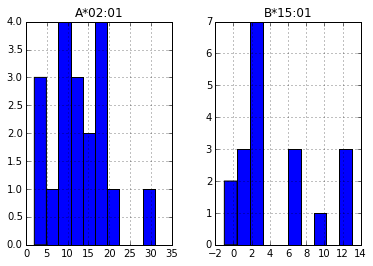

In [16]:
results.hist()

To combine prediction results we can use `merge_results` from `Fred2.Core`. In addition to the result object we want to merge, also have to specify the type of these objects (here `EpitopePredictionResult`). The function will return a merged results object of the same type.

In [17]:
results = [EpitopePredictorFactory(m).predict(peptides,alleles=alleles) 
                    for m in ["Syfpeithi","BIMAS","SMM","SVMHC"]]
df = results[0].merge_results(results[1:])
df

A*02:01      B*15:01
Seq                         Method                             
(F, I, A, S, N, G, V, K, L) bimas        13.511718     0.600000
                            smm         438.641785  4315.190768
                            svmhc        -0.358894    -0.836802
                            syfpeithi    25.000000     7.000000
(L, L, G, A, T, C, M, F, V) bimas       650.311200     4.000000
                            smm          27.108782  3689.775986
                            svmhc         0.969253    -0.548826
                            syfpeithi    22.000000    10.000000
(S, Y, F, P, E, I, T, H, I) bimas         0.012331     0.014400
                            smm        2931.635689  7014.552984
                            svmhc         0.096541    -0.524968
                            syfpeithi    17.000000     4.000000

We also can filter the predicted epitopes based on their prediction values with the function `filter_result` from `Fred2.Core`.

In [18]:
#you can either use pre-defined operators from `operator`
from operator import ge
#or define you own comparator function like this
comparator = lambda a,b: a > b

df.filter_result([("svmhc",comparator,0.0)])


A*02:01      B*15:01
Seq                         Method                             
(L, L, G, A, T, C, M, F, V) bimas       650.311200     4.000000
                            smm          27.108782  3689.775986
                            svmhc         0.969253    -0.548826
                            syfpeithi    22.000000    10.000000
(S, Y, F, P, E, I, T, H, I) bimas         0.012331     0.014400
                            smm        2931.635689  7014.552984
                            svmhc         0.096541    -0.524968
                            syfpeithi    17.000000     4.000000

With that one can combine several prediction tools to form a consensus prediction method.<br/><br/>
<h2> Chapter 3: Implementation of a new epitope prediction method </h2>
<br/>
Fred2 possesses a potent plugin system allowing the user to extend its capability quite easily. To include a new epitope prediction method one simply has to inherit from `Fred2.Core.AEpitopePrediction` and implement its interface. For methods calling an external prediction tool additionally have to inherit from `Fred2.Core.AExternal`. SVM based methods also define a specific interface via `Fred2.Core.ASVM`. Fred2 uses SVMlight and its python binding svmlight 0.4.

If you want to be very specific and fully integrate your method in all of Fred2's capabilities please use one of the three major interfaces `APSSMEpitopePrediction`, `ASVMEpitopePrediction`, or `AExternalEpitopePrediction` from `Fred2.EpitopePrediction`.

In [19]:
from Fred2.EpitopePrediction import APSSMEpitopePrediction
from Fred2.Core import EpitopePredictionResult
import random
import pandas

class RandomEpitopePrediction(APSSMEpitopePrediction):
    __alleles = ["A*02:01"]
    __supported_length = [9]
    __name = "random"
    __version= "1.0"
    
    #the interface defines three class properties
    @property
    def name(self):
        #retunrs the name of the predictor
        return self.__name
    
    @property
    def supportedAlleles(self):
        #returns the supported alleles as strings (without the HLA prefix)
        return self.__alleles
    
    @property
    def supportedLength(self):
        #returns the supported epitope lengths as iterable
        return self.__supported_length
    
    @property
    def version(self):
        #returns the version of the predictor
        return self.__version
    
    #the interface defines a function converting Fred2's HLA allele presentation
    #into an internal presentation used by different methods.
    #for this predictor we won't need it but still have to provide it!
    #the function consumes a list of alleles and converts them into the internally used presentation
    def convert_alleles(self, alleles):
        #we just use the identity function
        return alleles
    
    #additionally the interface defines a function `predict` 
    #that consumes a list of peptides or a single peptide and optionally a list 
    #of allele objects
    #
    #this method implements the complete prediction routine
    def predict(self, peptides, alleles=None):
        
        #test whether one peptide or a list
        if isinstance(peptides, basestring):
            peptides = list(peptides)
        
        #if no alleles are specified do predictions for all supported alleles
        if alleles is None:
            alleles = self.supportedAlleles
        else:
            #filter for supported alleles
            alleles = filter(lambda a: a.name in self.supportedAlleles, alleles) 
        
        result = {}
        #now predict binding/non-binding for each peptide at random
        for a in alleles:
            result[a] = {}
            for p in peptides:
                if random.random() >= 0.5:
                    result[a][p] = 1.0
                else:
                    result[a][p] = 0.0
        
        #create EpitopePredictionResult object. This is a multi-indexed DataFrame 
        #with Peptide and Method as multi-index and alleles as columns
        df_result = EpitopePredictionResult.from_dict(result)
        df_result.index = pandas.MultiIndex.from_tuples([tuple((i,self.name)) for i in df_result.index],
                                                        names=['Seq','Method'])
        return df_result
            
    
    
    

Now lets use our new predictor.

In [20]:
EpitopePredictorFactory("random").predict(peptides)

,,A*02:01
Seq,Method,
"(F, I, A, S, N, G, V, K, L)",random,1
"(L, L, G, A, T, C, M, F, V)",random,0
"(S, Y, F, P, E, I, T, H, I)",random,0


The predictor is now fully integrated and can be used in any context defined by Fred2.